# Overview
In this tutorial we first play with a metric derived from a kernel density estimate. This will allow us to develop simple geodesic algorithms.

Secondly, we will fit a simple VAE to a subset of the MNIST dataset and compute geodesics according to the pullback metric. Here we will use the density metric to initialize geodesics.

The bulk of the code merely provides a VAE implementation, which is of secondary importance for the tutorial.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.distributions as td
from torch.distributions.kl import kl_divergence as KL
from torchvision import datasets, transforms
import torch.utils.data
from tqdm import tqdm
import matplotlib.pyplot as plt

# Part 1: Density metrics and basic geodesic computations

We first define a Riemannian metric derived from a kernel density estimate of data.


Here you should write the code for evaluating the energy of the curve. See slide number 2 for a formal definition of the curve energy. Here you should make finite difference approximations to the curve derivative.

In [ ]:
class DensityMetric(nn.Module):
    def __init__(self, data, sigma):
        super(DensityMetric, self).__init__()
        self.data = data
        self.sigma = sigma

    def density(self, x):
        """
        Evaluate a kernel density estimate at x.

        Parameters:
        x: points where the density is evaluated. Dimensions (num_points)x(data_dim)
        """
        N, D = x.shape
        M, _ = self.data.shape
        sigma2 = self.sigma**2
        normalization = (2 * 3.14159)**(D/2) * self.sigma**D  # scalar
        distances = torch.cdist(x, self.data)  # NxM
        K = torch.exp(-0.5 * distances**2 / sigma2) / normalization  # NxM
        p = torch.sum(K, dim=1)  # N
        return p

    def curve_energy(self, C):
        """
        Compute the length of a curve when passed through the decoder mean.

        Parameters:
        C: points along a curve. Dimensions (batch)x(num_points_along_curve)x(data_dim)
        """
        pass # XXX: remove me!

        if C.dim() == 2:
            C = C.unsqueeze(0)
        B, lenT, D = C.shape
        CC = C.reshape(-1, D)
        p = self.density(CC)  # (B*lenT)

        # XXX: You shall implement the actual energy of a curve and return it

        return energy

Next we define a parametric family of curves that we will use to represent geodesics. For simplicity, we here just consider 2nd order polynomials. For more elaborate applications, we recommend using splines or similar expressive curves.

In [ ]:
class Poly2(nn.Module):
    def __init__(self, x0, x1, N):
        """
        Represent the second-order polynomial
          t --> a*t**2 + b**t + c

        a, b, c: [torch.Tensor]
           Polynomial coefficients. These must have identical dimensionality
        """
        super(Poly2, self).__init__()
        self.x0 = x0.reshape(1, -1)  # 1xD
        self.x1 = x1.reshape(1, -1)  # 1xD
        self.N = N

        self.w = nn.Parameter(torch.zeros_like(self.x0))  # 1xD

    def points(self):
        return self.forward(torch.linspace(0, 1, self.N))

    def forward(self, t):
        _t = t.reshape(-1, 1)  # Tx1
        line = (1 - _t) @ self.x0 + _t @ self.x1  # TxD
        a = -self.w  # 1xD
        b = self.w  # 1xD
        poly = ( _t**2) @ a + _t @ b  # TxD
        return line + poly  # TxD

    def plot(self, *args, **kwargs):
        c = self.points().detach().numpy()
        plt.plot(c[:, 0], c[:, 1], *args, **kwargs)

Geodesics can then be found by minimizing the energy of curves.

In [ ]:
def connecting_geodesic(model, curve, energy_fun, max_iter = 200, lr = 0.1):
    opt = torch.optim.RMSprop(curve.parameters(), lr=lr)
    def closure():
        opt.zero_grad()
        energy = energy_fun(model, curve)
        energy.backward()
        return energy

    for _ in range(max_iter):
        opt.zero_grad()
        energy = opt.step(closure)
    return energy

Finally, we fetch some simple data and compute a few geodesics

100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


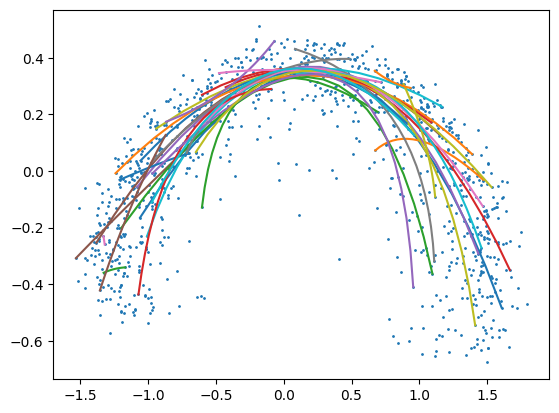

In [ ]:
try:
    toydata = np.load('toybanana.npy')
except:
    !wget http://hauberg.org/weekendwithbernie/toybanana.npy
    toydata = np.load('toybanana.npy')
data = torch.from_numpy(toydata).to(dtype=torch.float32)  # 992x2
dm = DensityMetric(data, 0.1)
dm_energy = lambda model, curve: dm.curve_energy(curve.points())

## Plot training data
plt.scatter(data[:, 0], data[:, 1], s=1)

## Plot random geodesics
num_curves = 30
curve_indices = torch.randint(data.shape[0], (num_curves, 2))  # (num_curves) x 2
with tqdm(range(num_curves)) as pbar:
    for k in pbar:
        i = curve_indices[k, 0]
        j = curve_indices[k, 1]
        c = Poly2(data[i], data[j], 20)
        connecting_geodesic(dm, c, energy_fun = dm_energy, max_iter = 200)
        c.plot('-')

# Part 2: Variational autoencoders, ensembles and pull-back metrics

We define a VAE through its latent prior, a decoder and an encoder. For the purpose of this tutorial, the details of this code is not important.

In [ ]:
class GaussianPrior(nn.Module):
    def __init__(self, M):
        """
        Define a Gaussian prior distribution with zero mean and unit variance.

                Parameters:
        M: [int]
           Dimension of the latent space.
        """
        super(GaussianPrior, self).__init__()
        self.M = M
        self.mean = nn.Parameter(torch.zeros(self.M), requires_grad=False)
        self.std = nn.Parameter(torch.ones(self.M), requires_grad=False)

    def forward(self):
        """
        Return the prior distribution.

        Returns:
        prior: [torch.distributions.Distribution]
        """
        return td.Independent(td.Normal(loc=self.mean, scale=self.std), 1)


class GaussianEncoder(nn.Module):
    def __init__(self, encoder_net):
        """
        Define a Gaussian encoder distribution based on a given encoder network.

        Parameters:
        encoder_net: [torch.nn.Module]
           The encoder network that takes as a tensor of dim `(batch_size,
           feature_dim1, feature_dim2)` and output a tensor of dimension
           `(batch_size, 2M)`, where M is the dimension of the latent space.
        """
        super(GaussianEncoder, self).__init__()
        self.encoder_net = encoder_net

    def forward(self, x):
        """
        Given a batch of data, return a Gaussian distribution over the latent space.

        Parameters:
        x: [torch.Tensor]
           A tensor of dimension `(batch_size, feature_dim1, feature_dim2)`
        """
        mean, std = torch.chunk(self.encoder_net(x), 2, dim=-1)
        return td.Independent(td.Normal(loc=mean, scale=torch.exp(std)), 1)


class BernoulliDecoder(nn.Module):
    def __init__(self, decoder_net):
        """
        Define a Bernoulli decoder distribution based on a given decoder network.

        Parameters:
        encoder_net: [torch.nn.Module]
           The decoder network that takes as a tensor of dim `(batch_size, M) as
           input, where M is the dimension of the latent space, and outputs a
           tensor of dimension (batch_size, feature_dim1, feature_dim2).
        """
        super(BernoulliDecoder, self).__init__()
        self.decoder_net = decoder_net
        self.std = nn.Parameter(torch.ones(28, 28)*0.5, requires_grad=True)

    def forward(self, z):
        """
        Given a batch of latent variables, return a Bernoulli distribution over the data space.

        Parameters:
        z: [torch.Tensor]
           A tensor of dimension `(batch_size, M)`, where M is the dimension of the latent space.
        """
        logits = self.decoder_net(z)
        return td.Independent(td.ContinuousBernoulli(logits=logits), 3)


class VAE(nn.Module):
    """
    Define a Variational Autoencoder (VAE) model.
    """
    def __init__(self, prior, decoder, encoder):
        """
        Parameters:
        prior: [torch.nn.Module]
           The prior distribution over the latent space.
        decoder: [torch.nn.Module]
              The decoder distribution over the data space.
        encoder: [torch.nn.Module]
                The encoder distribution over the latent space.
        """

        super(VAE, self).__init__()
        self.prior = prior
        self.decoder = decoder
        self.encoder = encoder

    def elbo(self, x):
        """
        Compute the ELBO for the given batch of data.

        Parameters:
        x: [torch.Tensor]
           A tensor of dimension `(batch_size, feature_dim1, feature_dim2, ...)`
           n_samples: [int]
           Number of samples to use for the Monte Carlo estimate of the ELBO.
        """
        q = self.encoder(x)
        z = q.rsample()
        elbo = torch.mean(self.decoder(z).log_prob(x) - q.log_prob(z) + self.prior().log_prob(z), dim=0)
        return elbo

    def sample(self, n_samples=1):
        """
        Sample from the model.

        Parameters:
        n_samples: [int]
           Number of samples to generate.
        """
        z = self.prior().sample(torch.Size([n_samples]))
        return self.decoder(z).sample()

    def forward(self, x):
        """
        Compute the negative ELBO for the given batch of data.

        Parameters:
        x: [torch.Tensor]
           A tensor of dimension `(batch_size, feature_dim1, feature_dim2)`
        """
        return -self.elbo(x)

    def curve_energy(self, C):
        """
        Compute the length of a curve when passed through the decoder mean.

        Parameters:
        C: points along a curve. Dimensions (num_points_along_curve)x(latent_dim)
        """
        lenT, latent_dim = C.shape
        ambient_C = self.decoder(C).mean  # |T| x (data_shape)

        delta = (ambient_C[1:] - ambient_C[:-1])  # (|T|-1) x (data_shape)
        retval = torch.sum(delta.reshape(lenT-1, -1)**2, dim=1).sum(dim=0)  # scalar
        return retval

The VAE training loop works by minimizing the negative ELBO (as usual). This is extended handle an ensemble of decoders to better reflect model uncertainty. This uncertainty, in turn, influences the practical topology of the latent space.

In [ ]:
def train(models, optimizers, data_loader, epochs, device):
    """
    Train a VAE model.

    Parameters:
    model: [VAE]
       The VAE model to train.
    optimizer: [torch.optim.Optimizer]
         The optimizer to use for training.
    data_loader: [torch.utils.data.DataLoader]
            The data loader to use for training.
    epochs: [int]
        Number of epochs to train for.
    device: [torch.device]
        The device to use for training.
    """
    num_ensembles = len(models)
    for m in range(num_ensembles):
        models[m].train()
    num_steps = num_ensembles*len(data_loader)*epochs
    epoch = 0

    def noise(x, std=0.1):  # std=0.05
        eps = std * torch.randn_like(x)
        return torch.clamp(x + eps, min=0.0, max=1.0)


    with tqdm(range(num_steps)) as pbar:
        for step in pbar:
            x = next(iter(data_loader))[0]
            x = noise(x.to(device))
            ensemble_idx = torch.randint(num_ensembles, (1,))
            model = models[ensemble_idx]
            optimizer = optimizers[ensemble_idx]
            optimizer.zero_grad()
            loss = model(x)
            loss.backward()
            optimizer.step()

            # Report
            if step % 5 ==0 :
                loss = loss.detach().cpu()
                pbar.set_description(f"epoch={epoch}, step={step}, loss={loss:.1f}")

            if (step+1) % len(data_loader) == 0:
                epoch += 1

We load a subset of the MNIST dataset to have something to fit our model.

In [ ]:
def subsample(data, targets, num_data, num_classes):
    idx = targets < num_classes
    new_data = data[idx][:num_data].unsqueeze(1).to(torch.float32) / 255
    new_targets = targets[idx][:num_data]

    return torch.utils.data.TensorDataset(new_data, new_targets)

num_train_data = 2048
num_classes = 3
train_tensors = datasets.MNIST('data/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_data = subsample(train_tensors.data, train_tensors.targets, num_train_data, num_classes)
mnist_train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)

Next we train a VAE ensemble. This takes about 5 minutes on CPU (much faster on GPU, so change the device if you have the hardware)

In [ ]:
torch.manual_seed(314159)
M = 2  # latent dimension is two for plotting
prior = GaussianPrior(M)

encoder_net = nn.Sequential(
    nn.Conv2d(1, 16, 3, stride=2, padding=1),
    nn.Softplus(),
    nn.Conv2d(16, 32, 3, stride=2, padding=1),
    nn.Flatten(),
    nn.Linear(1568, 2*M),
)

def new_decoder():
    decoder_net = nn.Sequential(
        nn.Linear(M, 512),
        nn.Unflatten(-1, (32, 4, 4)),
        nn.Softplus(),
        nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=0),
        nn.Softplus(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.Softplus(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
    )
    return decoder_net

# Define ensemble of VAE models
num_ensembles = 10
models, optimizers = [], []
encoder = GaussianEncoder(encoder_net)
for _ in range(num_ensembles):
    decoder = BernoulliDecoder(new_decoder())
    model = VAE(prior, decoder, encoder)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    models.append(model)
    optimizers.append(optimizer)

# Run the training loop
epochs = 10
device = 'cpu'
train(models, optimizers, mnist_train_loader, epochs, device)

epoch=99, step=6395, loss=-1251.0: 100%|██████████| 6400/6400 [02:56<00:00, 36.31it/s]


# Now comes the geometry part
So far we have trained a VAE to fit the data. Now we start making identifiable computations in latent space by computing geodesics.

We first define an energy measure that geodesics should minimize. This is merely the squared error, which is averaged across decoders. The latter step ensures that distances are large in regions of latent space where decoders disagree (regions of high model uncertainty). We use a Monte Carlo estimate of the average across decoders.

In [ ]:
def ensemble_energy(models, curve):
    num_models = len(models)
    C = curve.points()  # M x (latent_dim)
    M = C.shape[0]
    P = [model.decoder(C).mean.reshape(1, M, -1) for model in models]
    P = torch.concatenate(P, dim=0)  # (num_models) x M x 28²

    rp0 = torch.randperm(num_models)  # (num_models)
    rp1 = torch.randperm(num_models)  # (num_models)

    #p0 = td.Bernoulli(probs = P[rp0, 1:, :])  # (num_models) x (M-1) x 28²
    #p1 = td.Bernoulli(probs = P[rp1, :-1, :])  # (num_models) x (M-1) x 28²
    #E = KL(p0, p1)  # (num_models) x (M-1) x 28²
    E = (P[rp0, 1:, :] - P[rp1, :-1, :])**2
    return E.mean()

We encode the training data to get latent coordinates.

In [ ]:
## Put trained models in 'eval' mode
for m in range(num_ensembles):
    models[m].eval()

## Encode training data
latents, labels = [], []
with torch.no_grad():
    for x, y in mnist_train_loader:
        z = models[0].encoder(x)
        latents.append(z.mean)
        labels.append(y)
    latents = torch.concatenate(latents, dim=0)
    labels = torch.concatenate(labels, dim=0)

Finally, we plot the latent variables alongside randomly drawn geodesics.
This takes a couple of minutes as well since the provided implementation is optimized for readability over speed.

100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


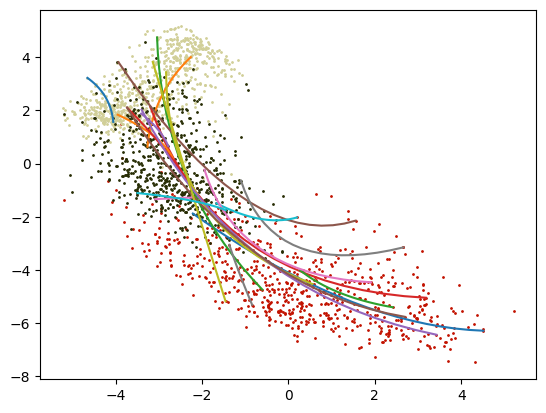

In [ ]:
## Plot training data
for k in range(num_classes):
    col = torch.rand(3).numpy()
    idx = labels == k
    plt.scatter(latents[idx, 0], latents[idx, 1], s=1, color=col)

## Plot random geodesics
num_curves = 20
dm = DensityMetric(latents, 0.5)
dm_energy = lambda model, curve: model.curve_energy(curve.points())
curve_indices = torch.randint(num_train_data, (num_curves, 2))  # (num_curves) x 2
with tqdm(range(num_curves)) as pbar:
    for k in pbar:
        i = curve_indices[k, 0]
        j = curve_indices[k, 1]
        c = Poly2(latents[i], latents[j], 20)
        connecting_geodesic(dm, c, energy_fun = dm_energy, max_iter = 100)  # initialization
        energy = connecting_geodesic(models, c, energy_fun = ensemble_energy, max_iter = 10, lr = 0.01)  # smaller learning rate as the energy i stochastic
        c.plot('-')

Here is my implementation of the curve energy of the density metric

In [ ]:
class DensityMetric(nn.Module):
    def __init__(self, data, sigma):
        super(DensityMetric, self).__init__()
        self.data = data
        self.sigma = sigma

    def density(self, x):
        """
        Evaluate a kernel density estimate at x.

        Parameters:
        x: points where the density is evaluated. Dimensions (num_points)x(data_dim)
        """
        N, D = x.shape
        M, _ = self.data.shape
        sigma2 = self.sigma**2
        normalization = (2 * 3.14159)**(D/2) * self.sigma**D  # scalar
        distances = torch.cdist(x, self.data)  # NxM
        K = torch.exp(-0.5 * distances**2 / sigma2) / normalization  # NxM
        p = torch.sum(K, dim=1)  # N
        return p

    def curve_energy(self, C):
        """
        Compute the length of a curve when passed through the decoder mean.

        Parameters:
        C: points along a curve. Dimensions (batch)x(num_points_along_curve)x(data_dim)
        """
        if C.dim() == 2:
            C = C.unsqueeze(0)
        B, lenT, D = C.shape
        CC = C.reshape(-1, D)
        p = self.density(CC)  # (B*lenT)
        metric = 1 / (p + 1e-4).reshape(B, lenT)  # (B)x(lenT)
        avg_metric = 0.5 * metric[:, 1:] + 0.5 * metric[:, :-1]  # (B)x(lenT-1)

        delta = C[:, 1:] - C[:, :-1]  # (B)x(lenT-1)x(D)
        energy = torch.sum(torch.sum(delta**2, dim=2) * avg_metric, dim=1)  # (B)

        return energy